In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from itertools import islice
import numpy as np
from skimage.external import tifffile
from skimage.external.tifffile import imread
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy.ma as ma
from skimage.measure import label, regionprops
from matplotlib.transforms import offset_copy

from sklearn.cluster import KMeans
import seaborn as sns
import plotly.express as px

# Pixel Distribution for HP1 signals

This script is to see the 'pixel distribution' of the images randomly selected from two experiments, which differ in which staining they have used. 10 samples will be chosen from each HP1 and HP1Beta groups, and each images and its HP1 (or HP1Beta) signals and DAPI signals will be assessed to find a difference between the HP1 stainings. 
<br>

# Contents
* [Data Loading](#data)
* [Sampling](#samples)
* [Data Analysis](#EDA)
    1. [first image](#1st)
    2. [second image](#2nd)
    3. [third image](#3rd)
* [Compare mean and max values](#meanMax)

## Pixel Distribution of HP1 (HP1B) and DAPI signal <a name="data"></a>
- Select random 10 cells from the chosen dataset
- calculate HP1 (HP1B) signal and DAPI signal for each pixel of the image
- plot HP1 signal vs DAPI signal for each cell 
- look for any pattern noticed - ex) normal linear relationship, grouping in the plots, etc

In [2]:
bigDir=r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading'

In [3]:
newfile=f'{bigDir}\\new dataset\signals_new_v5.csv'

In [4]:
newdata=pd.read_csv(newfile)

In [5]:
newdata=newdata.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [6]:
newdata.head()

file original cell name                       movie  \
0  20191203_cell-00.czi     20191125-01-17  191125pcnat_dhbr_cdc6vxy01   
1  20191203_cell-01.czi     20191125-01-20  191125pcnat_dhbr_cdc6vxy01   
2  20191203_cell-02.czi     20191125-01-23  191125pcnat_dhbr_cdc6vxy01   
3  20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
4  20191203_cell-04.czi     20191125-01-32  191125pcnat_dhbr_cdc6vxy01   

   last frame movie position x  last frame movie position y ab1 (MCM)  ab1 ch  \
0                      678.301                      200.931      MCM3       1   
1                     1552.152                      240.479      MCM3       1   
2                     1131.436                      318.530      MCM3       1   
3                     1650.585                      324.968      MCM3       1   
4                     1466.687                      426.815      MCM3       1   

  ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod nuc_hp1b_total  \
0               HP1beta       2        3  ...        0.444   1.415176e+09   
1               HP1beta       2        3  ...        1.373   2.175016e+09   
2               HP1beta       2        3  ...        1.371   1.933001e+09   
3               HP1beta       2        3  ...        0.208   1.062142e+09   
4               HP1beta       2        3  ...        0.345   1.717888e+09   

   inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  inner_hp1b_het  \
0       425500564.0      9.896759e+08  550518042.0     321679433.0   
1       804184935.0      1.370831e+09  896267478.0     567124747.0   
2       666820604.0      1.266180e+09  732487366.0     444813519.0   
3       233589820.0      8.285525e+08  403943621.0     187675893.0   
4       546330833.0      1.171557e+09  697150763.0     424718652.0   

  outer_hp1b_het   nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
0    228838609.0  8.646584e+08   103821131.0   7.608373e+08  
1    329142731.0  1.278748e+09   237060188.0   1.041688e+09  
2    287673847.0  1.200514e+09   222007085.0   9.785064e+08  
3    216267728.0  6.581987e+08    45913927.0   6.122848e+08  
4    272432111.0  1.020738e+09   121612181.0   8.991254e+08  

[5 rows x 59 columns]

In [7]:
file=f'{bigDir}\\20200217_geminin\\200217_cellinfo_v7.csv'

In [8]:
geminin=pd.read_csv(file)

In [9]:
geminin=geminin.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [10]:
geminin.head()

file     original cell name                         movie  \
0  20200217_cell_00.ciz  2020024-19-21-63X.czi  20200217pinducer gemininxy19   
1  20200217_cell_01.ciz  2020024-19-27-63X.czi  20200217pinducer gemininxy19   
2  20200217_cell_02.ciz  2020024-19-39-63X.czi  20200217pinducer gemininxy19   
3  20200217_cell_03.ciz  2020024-19-49-63X.czi  20200217pinducer gemininxy19   
4  20200217_cell_04.ciz  2020024-19-51-63X.czi  20200217pinducer gemininxy19   

          x        y ab1 (MCM)  ab1 ch ab2 (heterochromatin)  ab2 ch  DAPI ch  \
0  1312.741  235.893      MCM3       1                   HP1       2        3   
1  1323.444  397.761      MCM3       1                   HP1       2        3   
2  1772.297  584.995      MCM3       1                   HP1       2        3   
3   163.044  727.256      MCM3       1                   HP1       2        3   
4  1791.955  755.367      MCM3       1                   HP1       2        3   

   ...  outer_DAPI_total  nuc_DAPI_het inner_DAPI_het  outer_DAPI_het  \
0  ...      1.425797e+09  7.791948e+08   4.701984e+08     308996412.0   
1  ...      1.407304e+09  7.501514e+08   4.772260e+08     272925417.0   
2  ...      2.488888e+09  1.402612e+09   1.055936e+09     346675531.0   
3  ...      1.395355e+09  8.721556e+08   6.594996e+08     212655978.0   
4  ...      1.422570e+09  7.409389e+08   4.345226e+08     306416352.0   

    nuc_DAPI_eu inner_DAPI_eu outer_DAPI_eu        day physical_age  \
0  1.214105e+09    97303963.0  1.116801e+09  d20200217     8.833333   
1  1.302409e+09   168031096.0  1.134378e+09  d20200217     5.666667   
2  2.494576e+09   352363680.0  2.142212e+09  d20200217          NaN   
3  1.360779e+09   178079736.0  1.182699e+09  d20200217     7.833333   
4  1.222306e+09   106151998.0  1.116154e+09  d20200217     5.666667   

   mol_age_mod  
0        0.948  
1        0.465  
2        2.001  
3        1.063  
4        0.579  

[5 rows x 49 columns]

## Sampling  <a name="samples"></a>

sample = 10 samples from newdata; this data used ***HP1Beta***<br>
sample_geminin = 10 samples from geminin dataset; this data used ***HP1***

In [11]:
sample=newdata.loc[(newdata.decon==False),:]

In [12]:
sample=sample.loc[(['G1' in x for x in sample.category]), :].sample(n=10, random_state=107)

In [13]:
sample

file original cell name                       movie  \
102  20191203_cell-130.czi    20191125-08-101  191125pcnat_dhbr_cdc6vxy08   
3     20191203_cell-03.czi     20191125-01-25  191125pcnat_dhbr_cdc6vxy01   
108  20191203_cell-137.czi     20191125-11-82  191125pcnat_dhbr_cdc6vxy11   
58    20191203_cell-78.czi     20191125-05-44  191125pcnat_dhbr_cdc6vxy05   
49    20191203_cell-64.czi    20191125-10-142  191125pcnat_dhbr_cdc6vxy10   
67    20191203_cell-87.czi     20191125-05-88  191125pcnat_dhbr_cdc6vxy05   
81   20191203_cell-103.czi     20191125-07-55  191125pcnat_dhbr_cdc6vxy07   
60    20191203_cell-80.czi     20191125-05-56  191125pcnat_dhbr_cdc6vxy05   
95   20191203_cell-123.czi    20191125-07-125  191125pcnat_dhbr_cdc6vxy07   
5     20191203_cell-05.czi     20191125-01-36  191125pcnat_dhbr_cdc6vxy01   

     last frame movie position x  last frame movie position y ab1 (MCM)  \
102                     1237.094                     1258.126      MCM3   
3                       1650.585                      324.968      MCM3   
108                      916.914                      921.865      MCM3   
58                       947.721                      652.410      MCM3   
49                       520.447                     1594.921      MCM3   
67                       301.901                     1450.886      MCM3   
81                       598.905                      812.930      MCM3   
60                       467.635                      889.574      MCM3   
95                      1258.357                     1764.788      MCM3   
5                       1705.099                      468.246      MCM3   

     ab1 ch ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  mol_age_mod  \
102       1               HP1beta       2        3  ...        0.721   
3         1               HP1beta       2        3  ...        0.208   
108       1               HP1beta       2        3  ...        0.701   
58        1               HP1beta       2        3  ...        0.422   
49        1               HP1beta       2        3  ...        1.009   
67        1               HP1beta       2        3  ...        0.208   
81        1               HP1beta       2        3  ...        0.462   
60        1               HP1beta       2        3  ...        0.674   
95        1               HP1beta       2        3  ...        0.649   
5         1               HP1beta       2        3  ...        0.632   

    nuc_hp1b_total  inner_hp1b_total  outer_hp1b_total nuc_hp1b_het  \
102   1.285848e+09       390107622.0      8.957405e+08  487715875.0   
3     1.062142e+09       233589820.0      8.285525e+08  403943621.0   
108   1.340251e+09       442330664.0      8.979200e+08  509021593.0   
58    1.216596e+09       363577325.0      8.530182e+08  456375018.0   
49    1.448302e+09       408907699.0      1.039394e+09  561312449.0   
67    1.173185e+09       255938367.0      9.172463e+08  438885958.0   
81    1.039684e+09       208705380.0      8.309790e+08  384549104.0   
60    1.373778e+09       453944387.0      9.198338e+08  519606383.0   
95    1.204104e+09       355183847.0      8.489197e+08  434319799.0   
5     1.615431e+09       530009467.0      1.085421e+09  699466569.0   

     inner_hp1b_het outer_hp1b_het  nuc_hp1b_eu inner_hp1b_eu  outer_hp1b_eu  
102     290984487.0    196731388.0  798132293.0    99123135.0    699009158.0  
3       187675893.0    216267728.0  658198734.0    45913927.0    612284807.0  
108     325983023.0    183038570.0  831229094.0   116347641.0    714881453.0  
58      263518999.0    192856019.0  760220527.0   100058326.0    660162201.0  
49      288467325.0    272845124.0  886989714.0   120440374.0    766549340.0  
67      196474325.0    242411633.0  734298719.0    59464042.0    674834677.0  
81      167188893.0    217360211.0  655135258.0    41516487.0    613618771.0  
60      326294309.0    193312074.0  854171789.0   127650078.0    726521711.0  
95      257178787.0    177141012.0  769783719.0    98005060.0 

In [14]:
sample_geminin=geminin.loc[(geminin.group=='CTL'),:]

sample_geminin=sample_geminin.loc[(['G1' in x for x in sample_geminin.category]), :].sample(n=10, random_state=107)

sample_geminin

file      original cell name  \
55  20200217_cell_56.ciz   2020024-21-69-63X.czi   
52  20200217_cell_53.ciz   2020024-21-56-63X.czi   
41  20200217_cell_41.ciz  2020024-20-129-63X.czi   
33  20200217_cell_33.ciz   2020024-20-72-63X.czi   
0   20200217_cell_00.ciz   2020024-19-21-63X.czi   
39  20200217_cell_39.ciz  2020024-20-111-63X.czi   
59  20200217_cell_60.ciz   2020024-21-91-63X.czi   
58  20200217_cell_59.ciz   2020024-21-84-63X.czi   
9   20200217_cell_09.ciz   2020024-19-79-63X.czi   
12  20200217_cell_12.ciz   2020024-19-93-63X.czi   

                           movie         x         y ab1 (MCM)  ab1 ch  \
55  20200217pinducer gemininxy21  1679.774   853.901      MCM3       1   
52  20200217pinducer gemininxy21   491.477   686.327      MCM3       1   
41  20200217pinducer gemininxy20   956.116  1670.198      MCM3       1   
33  20200217pinducer gemininxy20   693.390   929.068      MCM3       1   
0   20200217pinducer gemininxy19  1312.741   235.893      MCM3       1   
39  20200217pinducer gemininxy20  1306.021  1454.848      MCM3       1   
59  20200217pinducer gemininxy21  1292.148  1095.184      MCM3       1   
58  20200217pinducer gemininxy21  1388.189  1001.713      MCM3       1   
9   20200217pinducer gemininxy19   398.674  1037.764      MCM3       1   
12  20200217pinducer gemininxy19  1841.328  1182.675      MCM3       1   

   ab2 (heterochromatin)  ab2 ch  DAPI ch  ...  outer_DAPI_total nuc_DAPI_het  \
55                   HP1       2        3  ...      1.831348e+09  735528431.0   
52                   HP1       2        3  ...      1.325073e+09  989964835.0   
41                   HP1       2        3  ...      1.430629e+09  825203997.0   
33                   HP1       2        3  ...      1.555030e+09  993091013.0   
0                    HP1       2        3  ...      1.425797e+09  779194775.0   
39                   HP1       2        3  ...      1.181791e+09  760838823.0   
59                   HP1       2        3  ...      1.531307e+09  911067747.0   
58                   HP1       2        3  ...      1.460786e+09  894902823.0   
9                    HP1       2        3  ...      1.525443e+09  890740746.0   
12                   HP1       2        3  ...      1.530362e+09  839243088.0   

   inner_DAPI_het  outer_DAPI_het   nuc_DAPI_eu inner_DAPI_eu outer_DAPI_eu  \
55    342193413.0     393335018.0  1.575331e+09   137317117.0  1.438013e+09   
52    799149458.0     190815377.0  1.367327e+09   233069560.0  1.134257e+09   
41    592632646.0     232571351.0  1.346245e+09   148187340.0  1.198057e+09   
33    752317813.0     240773200.0  1.507446e+09   193189960.0  1.314256e+09   
0     470198363.0     308996412.0  1.214105e+09    97303963.0  1.116801e+09   
39    603861106.0     156977717.0  1.152483e+09   127669744.0  1.024813e+09   
59    625595380.0     285472367.0  1.462186e+09   216351806.0  1.245835e+09   
58    644872562.0     250030261.0  1.406651e+09   195894622.0  1.210756e+09   
9     604191565.0     286549181.0  1.412280e+09   173386032.0  1.238894e+09   
12    548132923.0     291110165.0  1.350745e+09   111493747.0  1.239252e+09   

          day physical_age  mol_age_mod  
55  d20200217     7.166667        0.913  
52  d20200217     2.833333        0.312  
41  d20200217     7.333333        0.980  
33  d20200217     9.666667        1.098  
0   d20200217     8.833333        0.948  
39  d20200217     3.166667        0.282  
59  d20200217     5.000000        0.222  
58  d20200217     7.333333        0.844  
9   d20200217     6.833333        0.726  
12  d20200217     2.000000        0.429  

[10 rows x 49 columns]

1. plot 10 graphs for each category
2. plot these 10 graphs as subplots of a figure

In [15]:
hp1betaDF=pd.DataFrame(columns=['File','HP1','DAPI'])

In [16]:
hp1DF=pd.DataFrame(columns=['File','HP1','DAPI'])

In [17]:
for i,row in sample.iterrows():
    cell=imread(row.path)
    hp1betaDF.loc[i,'File']=row.file
    nucPath=(row.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)

    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1b=cell[:,1,:,:] 
    ## masking the image
    hp1b[~nuc]=0
    hp1b=hp1b.astype(np.ndarray)
    hp1b=hp1b.ravel()
    hp1bFinal=hp1b[hp1b!=hp1b.max()]
    hp1betaDF.loc[i,'HP1']=hp1bFinal

    # DAPI channel
    dapiB=cell[:,2,:,:]
    dapiB[~nuc]=0
    dapiB=dapiB.ravel()
    dapiBFinal=dapiB[hp1b!=hp1b.max()]
    hp1betaDF.loc[i,'DAPI']=dapiBFinal

## HP1, geminin dataset
for i,row in sample_geminin.iterrows():
    cell=imread(row.path)
    hp1DF.loc[i,'File']=row.file
    
    nucPath=(row.path.replace('data_tiff','segmentation_nucleus_Otsu'))
    nucPath=nucPath.replace('.tif','_nucleus.tif')
    nuc=imread(nucPath)

    nuc=nuc.astype(bool)
    # selecting every slide of the selected channel, which is hp1beta channel.
    hp1=cell[:,1,:,:] 
    ## masking the image
    hp1[~nuc]=0
    hp1=hp1.astype(np.ndarray)
    hp1=hp1.ravel()
    hp1Final=hp1[hp1!=hp1.max()]
    hp1DF.loc[i,'HP1']=hp1Final
    
    # DAPI channel
    dapi=cell[:,2,:,:]
    dapi[~nuc]=0
    dapi=dapi.ravel()
    dapiFinal=dapi[hp1!=hp1.max()]
    hp1DF.loc[i,'DAPI']=dapiFinal


In [18]:
hp1betaDF=hp1betaDF.reset_index(drop=True)
hp1betaDF.head()

File                                                HP1  \
0  20191203_cell-130.czi  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1   20191203_cell-03.czi  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  20191203_cell-137.czi  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3   20191203_cell-78.czi  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4   20191203_cell-64.czi  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                DAPI  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [19]:
hp1DF=hp1DF.reset_index(drop=True)
hp1DF.head()

File                                                HP1  \
0  20200217_cell_56.ciz  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  20200217_cell_53.ciz  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  20200217_cell_41.ciz  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  20200217_cell_33.ciz  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  20200217_cell_00.ciz  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                DAPI  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

# HP1Beta signals

In [20]:
i=0

<IPython.core.display.Javascript object>


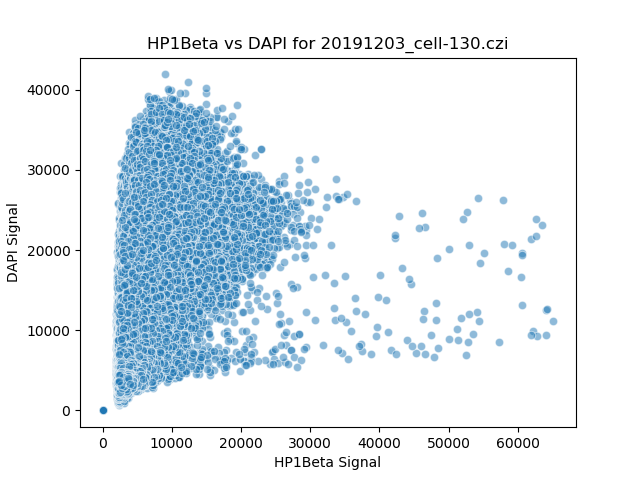

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-130.czi')

In [44]:
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


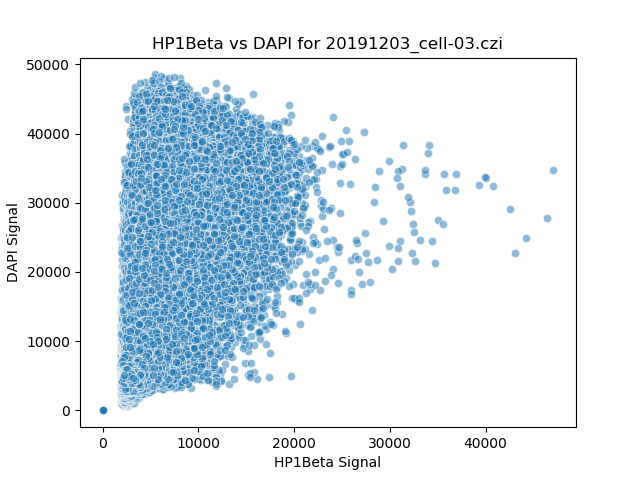

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-03.czi')

In [45]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

In [21]:
i=2

<IPython.core.display.Javascript object>


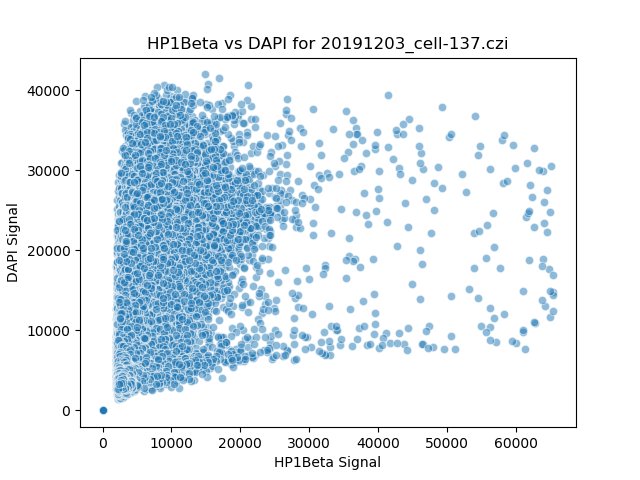

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-137.czi')

In [22]:
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


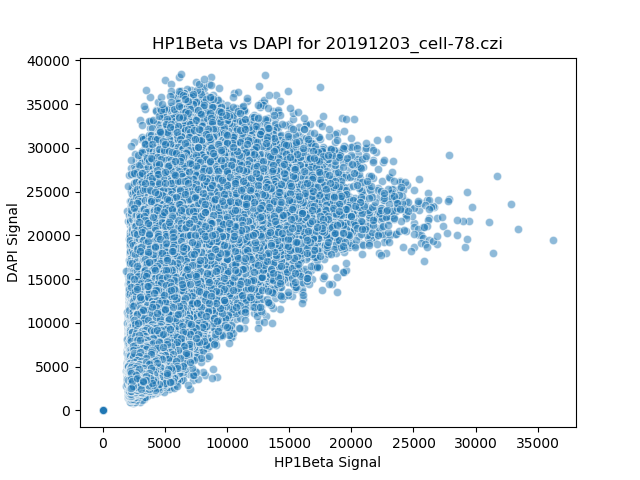

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-78.czi')

In [49]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


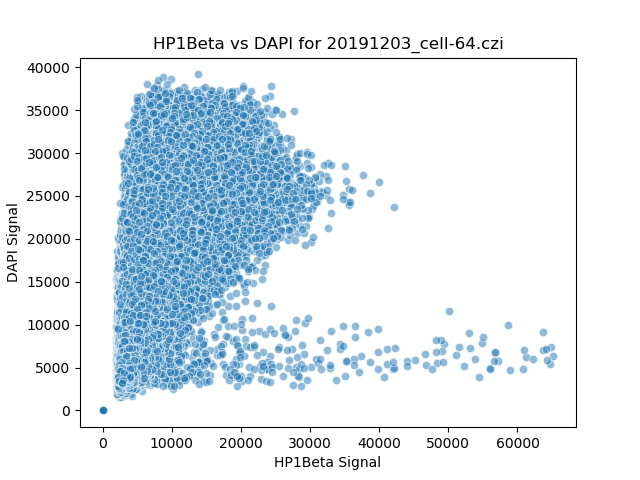

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-64.czi')

In [50]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


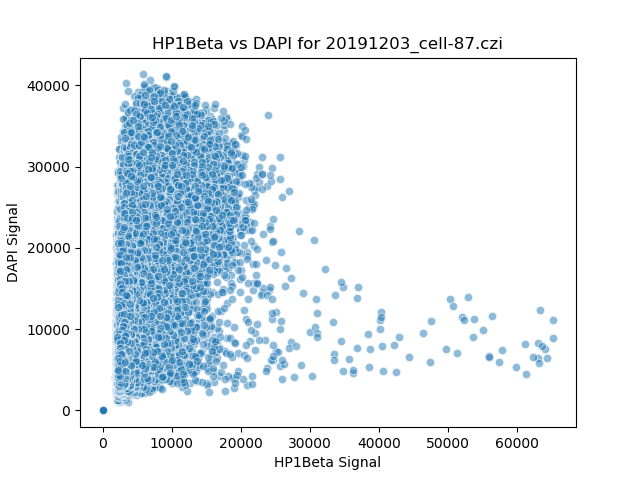

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-87.czi')

In [51]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


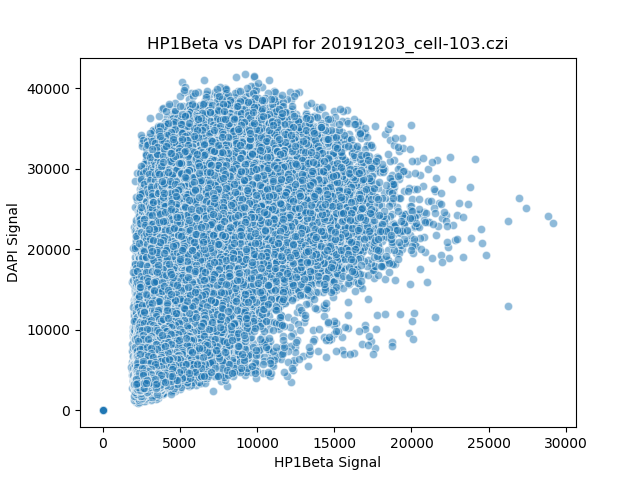

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-103.czi')

In [52]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


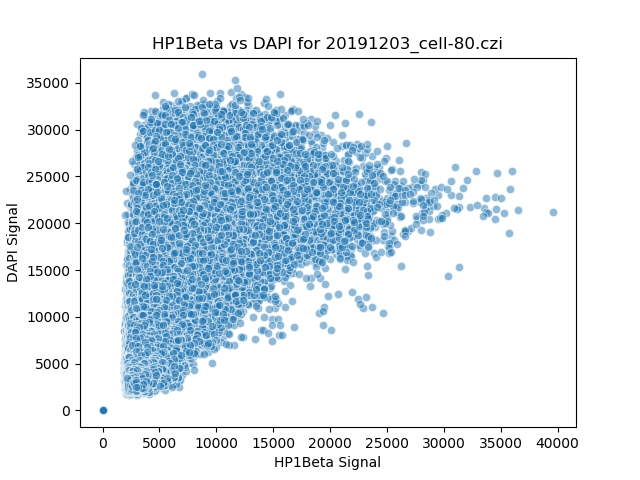

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-80.czi')

In [54]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


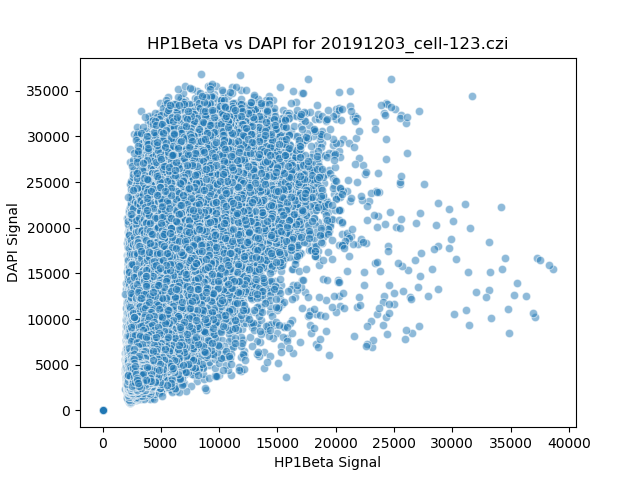

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-123.czi')

In [55]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

<IPython.core.display.Javascript object>


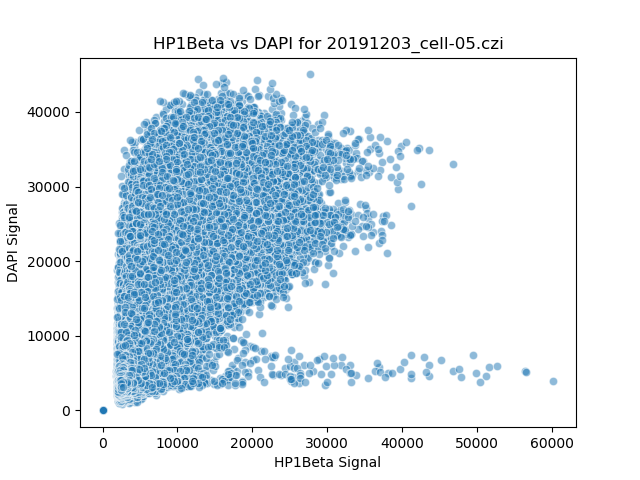

Text(0.5, 1.0, 'HP1Beta vs DAPI for 20191203_cell-05.czi')

In [56]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1betaDF.iloc[i],alpha=0.5)
plt.xlabel('HP1Beta Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1Beta vs DAPI for {hp1betaDF.at[i,"File"]}')

# HP1 Signals

<IPython.core.display.Javascript object>


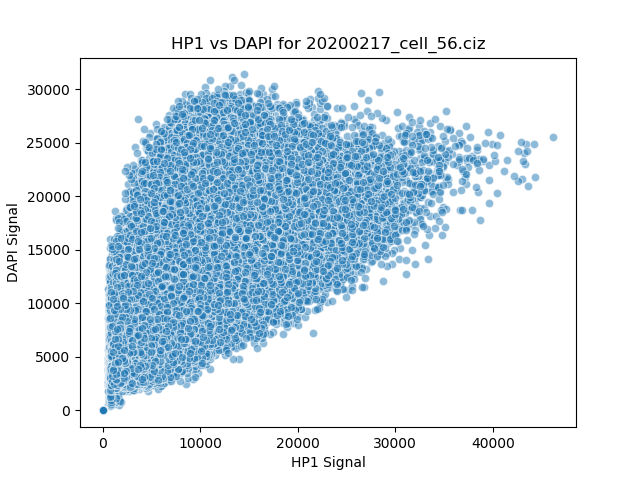

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_56.ciz')

In [23]:
i=0
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


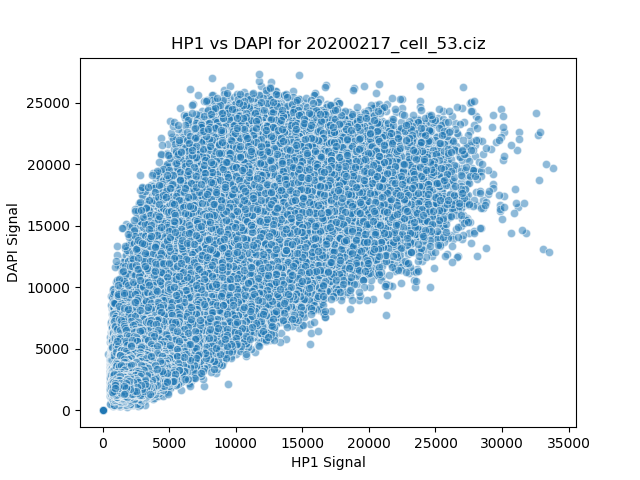

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_53.ciz')

In [24]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


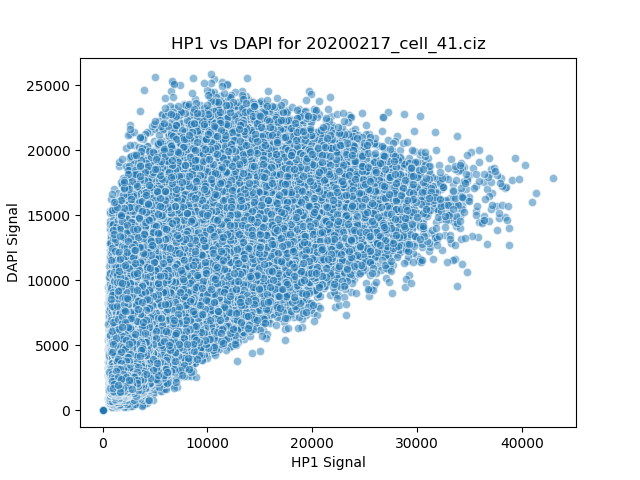

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_41.ciz')

In [25]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


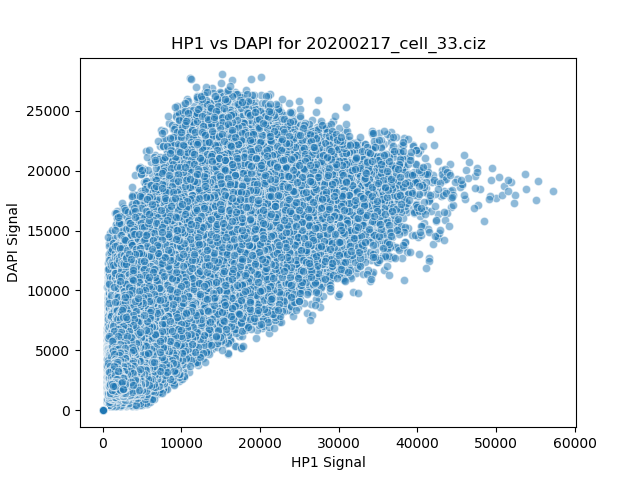

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_33.ciz')

In [26]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


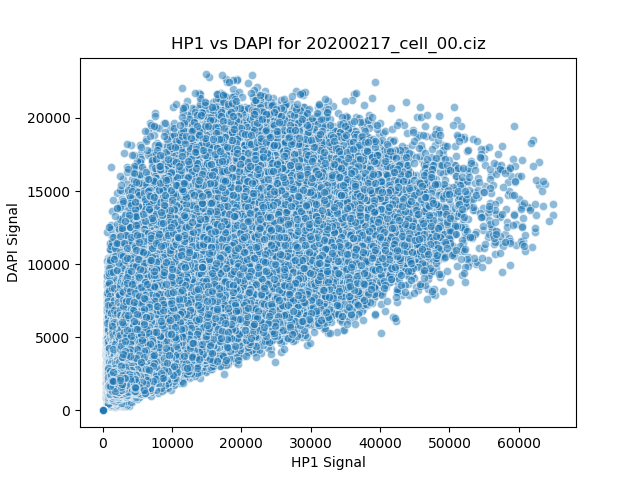

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_00.ciz')

In [27]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


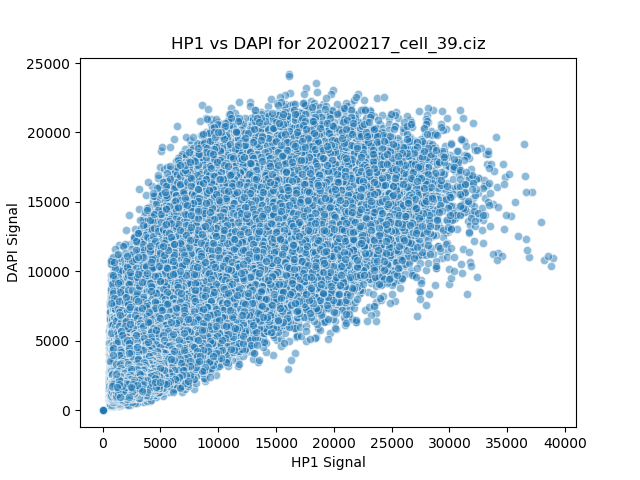

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_39.ciz')

In [28]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


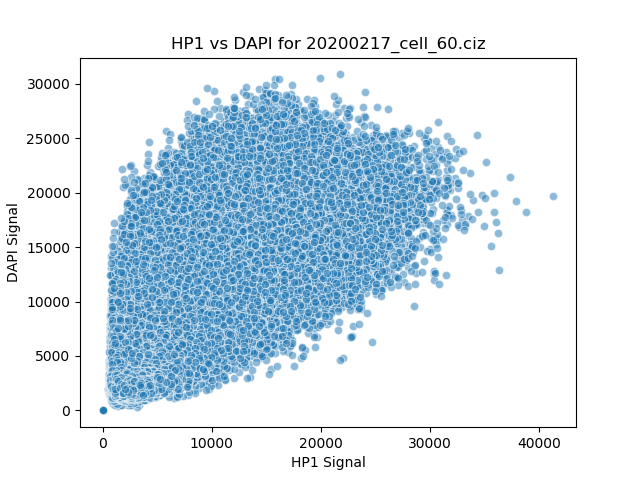

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_60.ciz')

In [29]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


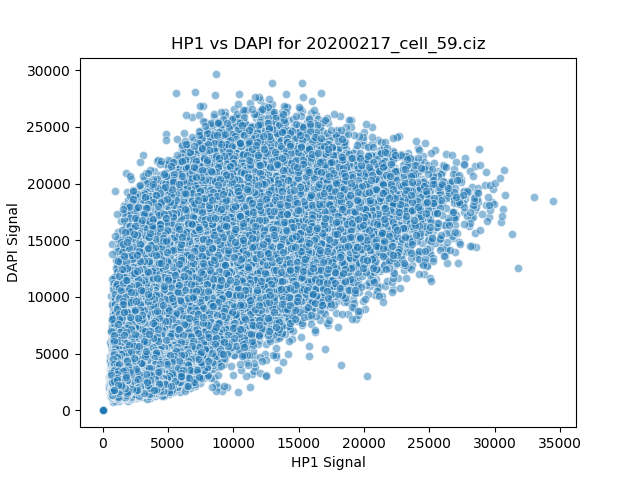

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_59.ciz')

In [32]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


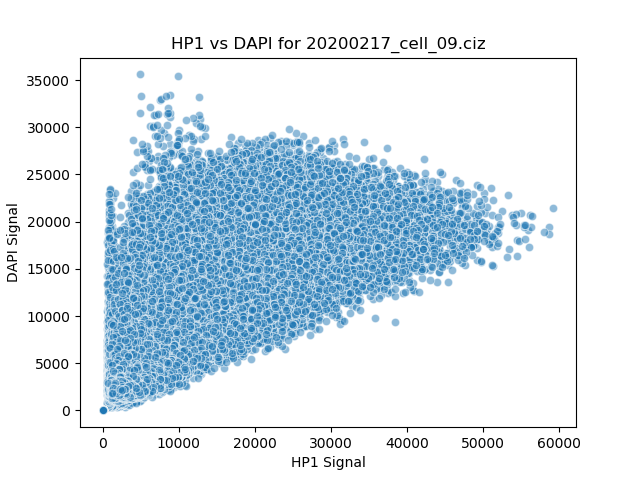

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_09.ciz')

In [33]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

<IPython.core.display.Javascript object>


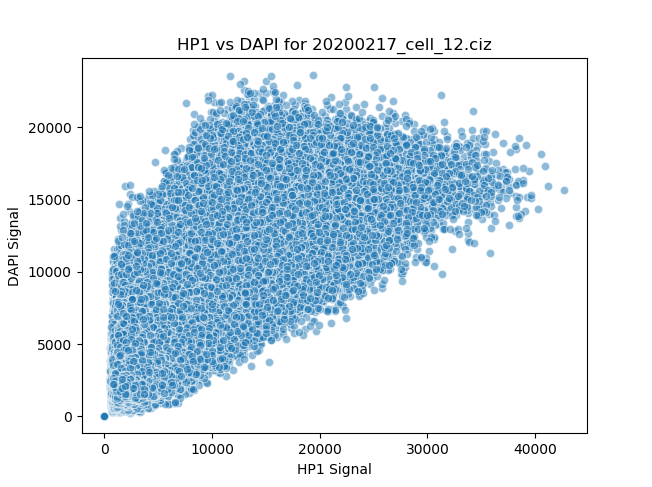

Text(0.5, 1.0, 'HP1 vs DAPI for 20200217_cell_12.ciz')

In [34]:
i+=1
%matplotlib notebook
sns.scatterplot(x='HP1',y='DAPI',data=hp1DF.iloc[i],alpha=0.5)
plt.xlabel('HP1 Signal')
plt.ylabel('DAPI Signal')
plt.title(f'HP1 vs DAPI for {hp1DF.at[i,"File"]}')

# Sample plots in one figure

In [20]:
hp1betaSample=pd.DataFrame(columns=['File','HP1','DAPI'])

In [21]:
for i, row in hp1betaDF.iterrows():
    idx = np.random.choice(np.arange(len(hp1betaDF.loc[i,'HP1'])), 1000, replace=False)
    hp1b_test=hp1betaDF.loc[i,'HP1']
    dapi_test=hp1betaDF.loc[i,'DAPI']
    
    hp1b_test_sample = hp1b_test[idx]
    dapiB_test_sample = dapi_test[idx]
    
    hp1betaSample.loc[i,'File']=row.File
    hp1betaSample.loc[i,'HP1']=hp1b_test_sample
    hp1betaSample.loc[i,'DAPI']=dapiB_test_sample

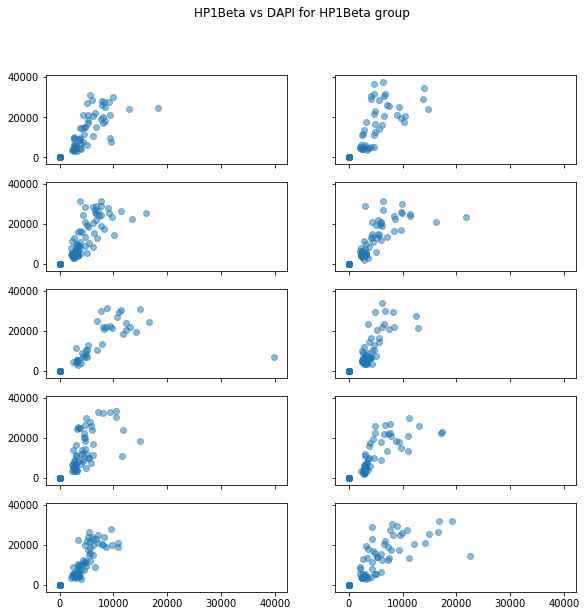

In [24]:
%matplotlib notebook
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all',figsize=(9.5,9.5))

fig.suptitle('HP1Beta vs DAPI for HP1Beta group')
ax[0,0].scatter(hp1betaSample.loc[0,'HP1'], hp1betaSample.loc[0,'DAPI'],alpha=0.5)
ax[0,1].scatter(hp1betaSample.loc[1,'HP1'], hp1betaSample.loc[1,'DAPI'],alpha=0.5)
ax[1,0].scatter(hp1betaSample.loc[2,'HP1'], hp1betaSample.loc[2,'DAPI'],alpha=0.5)
ax[1,1].scatter(hp1betaSample.loc[3,'HP1'], hp1betaSample.loc[3,'DAPI'],alpha=0.5)
ax[2,0].scatter(hp1betaSample.loc[4,'HP1'], hp1betaSample.loc[4,'DAPI'],alpha=0.5)
ax[2,1].scatter(hp1betaSample.loc[5,'HP1'], hp1betaSample.loc[5,'DAPI'],alpha=0.5)
ax[3,0].scatter(hp1betaSample.loc[6,'HP1'], hp1betaSample.loc[6,'DAPI'],alpha=0.5)
ax[3,1].scatter(hp1betaSample.loc[7,'HP1'], hp1betaSample.loc[7,'DAPI'],alpha=0.5)
ax[4,0].scatter(hp1betaSample.loc[8,'HP1'], hp1betaSample.loc[8,'DAPI'],alpha=0.5)
ax[4,1].scatter(hp1betaSample.loc[9,'HP1'], hp1betaSample.loc[9,'DAPI'],alpha=0.5)

In [27]:
hp1Sample=pd.DataFrame(columns=['File','HP1','DAPI'])

for i, row in hp1DF.iterrows():
    idx = np.random.choice(np.arange(len(hp1DF.loc[i,'HP1'])), 1000, replace=False)
    hp1_test=hp1DF.loc[i,'HP1']
    dapi_test=hp1DF.loc[i,'DAPI']
    
    hp1_test_sample = hp1_test[idx]
    dapi_test_sample = dapi_test[idx]
    
    hp1Sample.loc[i,'File']=row.File
    hp1Sample.loc[i,'HP1']=hp1_test_sample
    hp1Sample.loc[i,'DAPI']=dapi_test_sample

<IPython.core.display.Javascript object>


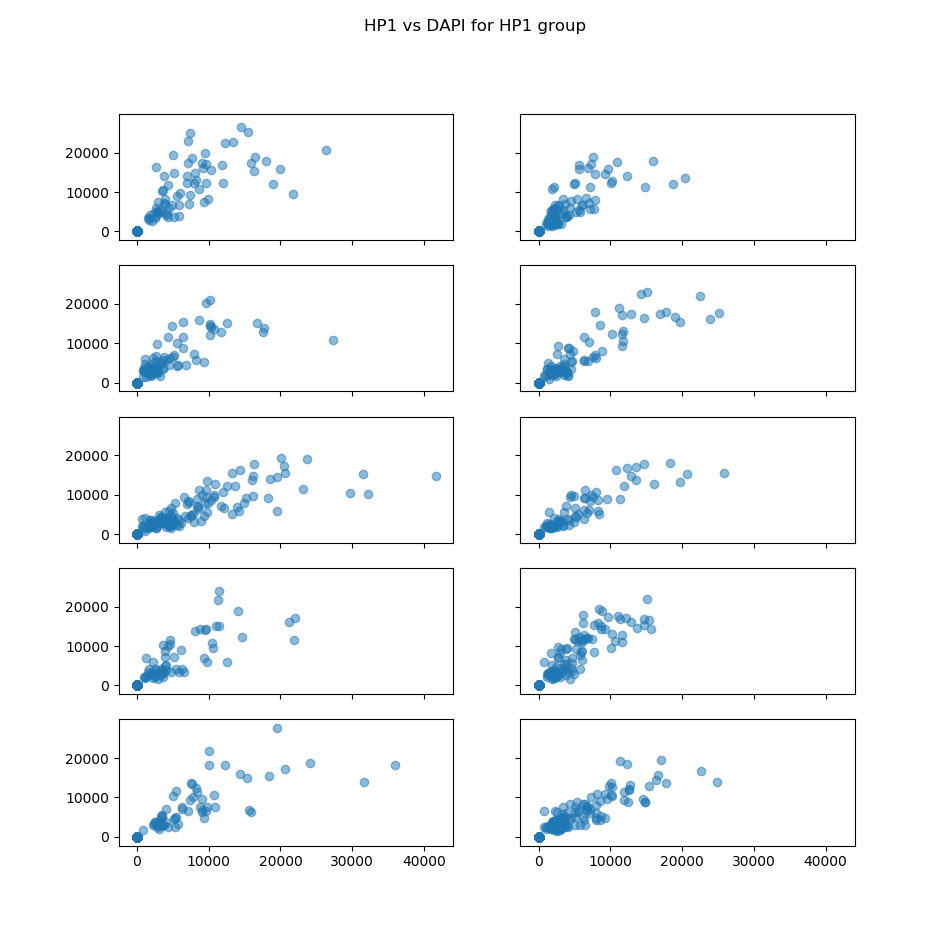

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all',figsize=(9.5,9.5))

fig.suptitle('HP1 vs DAPI for HP1 group')
ax[0,0].scatter(hp1Sample.loc[0,'HP1'], hp1Sample.loc[0,'DAPI'],alpha=0.5)
ax[0,1].scatter(hp1Sample.loc[1,'HP1'], hp1Sample.loc[1,'DAPI'],alpha=0.5)
ax[1,0].scatter(hp1Sample.loc[2,'HP1'], hp1Sample.loc[2,'DAPI'],alpha=0.5)
ax[1,1].scatter(hp1Sample.loc[3,'HP1'], hp1Sample.loc[3,'DAPI'],alpha=0.5)
ax[2,0].scatter(hp1Sample.loc[4,'HP1'], hp1Sample.loc[4,'DAPI'],alpha=0.5)
ax[2,1].scatter(hp1Sample.loc[5,'HP1'], hp1Sample.loc[5,'DAPI'],alpha=0.5)
ax[3,0].scatter(hp1Sample.loc[6,'HP1'], hp1Sample.loc[6,'DAPI'],alpha=0.5)
ax[3,1].scatter(hp1Sample.loc[7,'HP1'], hp1Sample.loc[7,'DAPI'],alpha=0.5)
ax[4,0].scatter(hp1Sample.loc[8,'HP1'], hp1Sample.loc[8,'DAPI'],alpha=0.5)
ax[4,1].scatter(hp1Sample.loc[9,'HP1'], hp1Sample.loc[9,'DAPI'],alpha=0.5)

# sample groups with zero values removed

In [29]:
for i, row in hp1betaDF.iterrows():
    hp1b_test=hp1betaDF.loc[i,'HP1']
    dapi_test=hp1betaDF.loc[i,'DAPI']
    
    hp1b_test_non_zero=hp1b_test[hp1b_test!=0]
    dapi_test_non_zero=dapi_test[hp1b_test!=0]
    
    idx = np.random.choice(np.arange(len(hp1b_test_non_zero)), 1000, replace=False)

    hp1b_test_sample = hp1b_test_non_zero[idx]
    dapiB_test_sample = dapi_test_non_zero[idx]
    
    hp1betaSample.loc[i,'File']=row.File
    hp1betaSample.loc[i,'HP1']=hp1b_test_sample
    hp1betaSample.loc[i,'DAPI']=dapiB_test_sample

In [30]:
hp1betaSample.head()

File                                                HP1  \
0  20191203_cell-130.czi  [4443, 3895, 8106, 3573, 3421, 2384, 9072, 239...   
1   20191203_cell-03.czi  [4832, 3195, 3725, 9627, 7078, 6848, 5358, 248...   
2  20191203_cell-137.czi  [4753, 3736, 5132, 2231, 3346, 2600, 3478, 354...   
3   20191203_cell-78.czi  [3568, 2885, 4265, 2865, 6003, 2884, 3463, 321...   
4   20191203_cell-64.czi  [3990, 10203, 14604, 6113, 4063, 3506, 7136, 2...   

                                                DAPI  
0  [4068, 10571, 18847, 5171, 4038, 3934, 26833, ...  
1  [9367, 19157, 12919, 33621, 21550, 29588, 3826...  
2  [13164, 6830, 9353, 3207, 20387, 4369, 16847, ...  
3  [15253, 6623, 10224, 4995, 14056, 3932, 10634,...  
4  [5413, 27269, 29069, 20548, 11260, 6923, 10659...

In [31]:
len(hp1betaSample.loc[0,'HP1'])

1000

## HP1Beta group

<IPython.core.display.Javascript object>


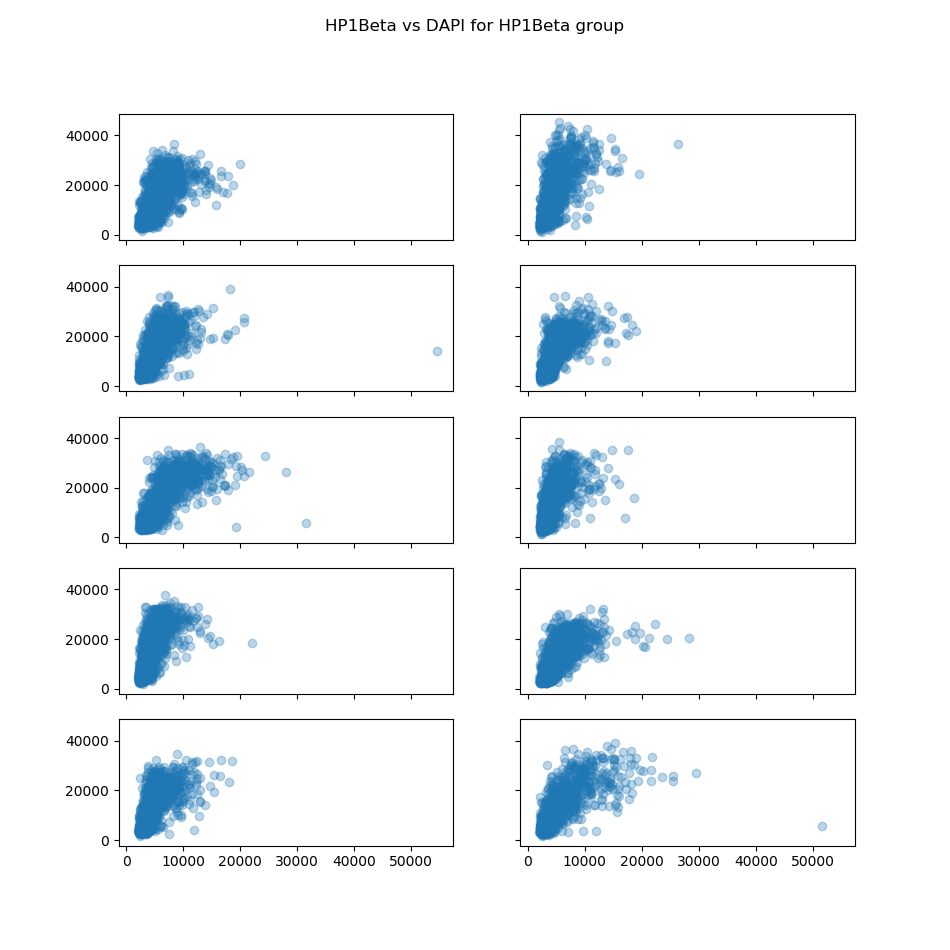

In [32]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all',figsize=(9.5,9.5))

fig.suptitle('HP1Beta vs DAPI for HP1Beta group')
ax[0,0].scatter(hp1betaSample.loc[0,'HP1'], hp1betaSample.loc[0,'DAPI'],alpha=0.3)
ax[0,1].scatter(hp1betaSample.loc[1,'HP1'], hp1betaSample.loc[1,'DAPI'],alpha=0.3)
ax[1,0].scatter(hp1betaSample.loc[2,'HP1'], hp1betaSample.loc[2,'DAPI'],alpha=0.3)
ax[1,1].scatter(hp1betaSample.loc[3,'HP1'], hp1betaSample.loc[3,'DAPI'],alpha=0.3)
ax[2,0].scatter(hp1betaSample.loc[4,'HP1'], hp1betaSample.loc[4,'DAPI'],alpha=0.3)
ax[2,1].scatter(hp1betaSample.loc[5,'HP1'], hp1betaSample.loc[5,'DAPI'],alpha=0.3)
ax[3,0].scatter(hp1betaSample.loc[6,'HP1'], hp1betaSample.loc[6,'DAPI'],alpha=0.3)
ax[3,1].scatter(hp1betaSample.loc[7,'HP1'], hp1betaSample.loc[7,'DAPI'],alpha=0.3)
ax[4,0].scatter(hp1betaSample.loc[8,'HP1'], hp1betaSample.loc[8,'DAPI'],alpha=0.3)
ax[4,1].scatter(hp1betaSample.loc[9,'HP1'], hp1betaSample.loc[9,'DAPI'],alpha=0.3)

In [33]:
hp1Sample=pd.DataFrame(columns=['File','HP1','DAPI'])

for i, row in hp1DF.iterrows():
    hp1_test=hp1DF.loc[i,'HP1']
    dapi_test=hp1DF.loc[i,'DAPI']
    
    hp1_test_non_zero=hp1_test[hp1_test!=0]
    dapi_test_non_zero=dapi_test[hp1_test!=0]
    
    idx = np.random.choice(np.arange(len(hp1_test_non_zero)), 1000, replace=False)

    hp1_test_sample = hp1_test_non_zero[idx]
    dapi_test_sample = dapi_test_non_zero[idx]
    
    hp1Sample.loc[i,'File']=row.File
    hp1Sample.loc[i,'HP1']=hp1_test_sample
    hp1Sample.loc[i,'DAPI']=dapi_test_sample

## HP1 group

<IPython.core.display.Javascript object>


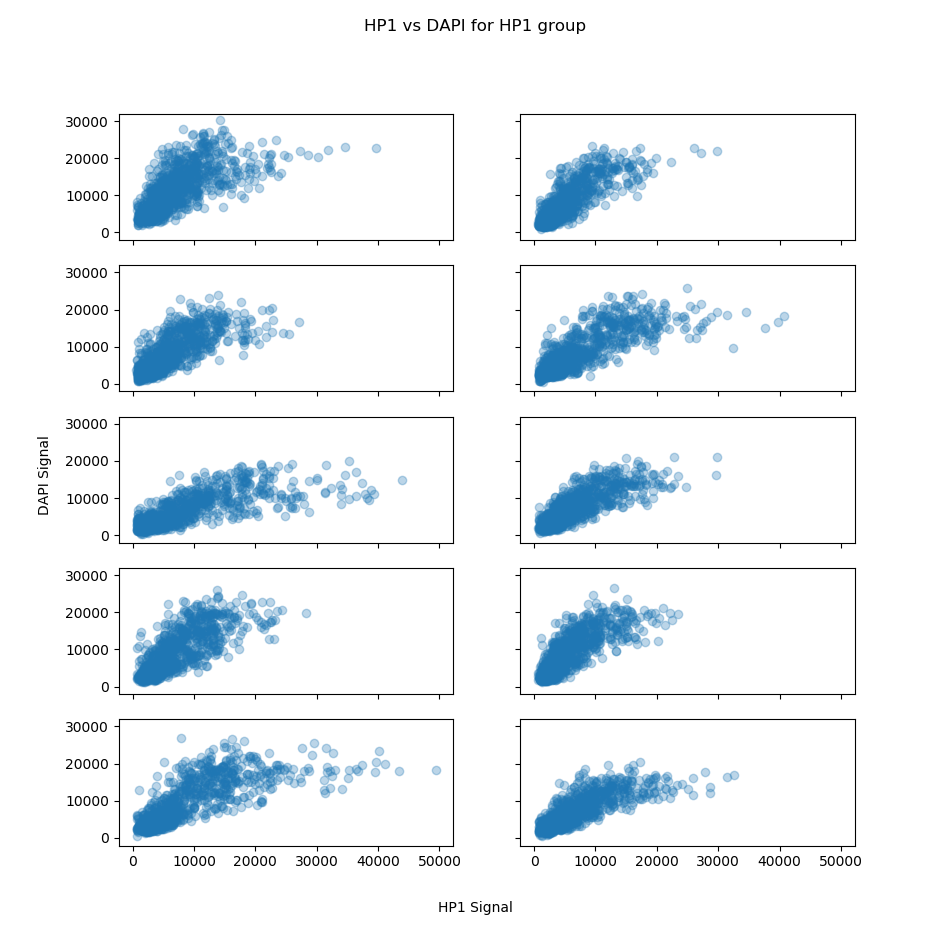

Text(0.04, 0.5, 'DAPI Signal')

In [40]:
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all',figsize=(9.5,9.5))

fig.suptitle('HP1 vs DAPI for HP1 group')
ax[0,0].scatter(hp1Sample.loc[0,'HP1'], hp1Sample.loc[0,'DAPI'],alpha=0.3)
ax[0,1].scatter(hp1Sample.loc[1,'HP1'], hp1Sample.loc[1,'DAPI'],alpha=0.3)
ax[1,0].scatter(hp1Sample.loc[2,'HP1'], hp1Sample.loc[2,'DAPI'],alpha=0.3)
ax[1,1].scatter(hp1Sample.loc[3,'HP1'], hp1Sample.loc[3,'DAPI'],alpha=0.3)
ax[2,0].scatter(hp1Sample.loc[4,'HP1'], hp1Sample.loc[4,'DAPI'],alpha=0.3)
ax[2,1].scatter(hp1Sample.loc[5,'HP1'], hp1Sample.loc[5,'DAPI'],alpha=0.3)
ax[3,0].scatter(hp1Sample.loc[6,'HP1'], hp1Sample.loc[6,'DAPI'],alpha=0.3)
ax[3,1].scatter(hp1Sample.loc[7,'HP1'], hp1Sample.loc[7,'DAPI'],alpha=0.3)
ax[4,0].scatter(hp1Sample.loc[8,'HP1'], hp1Sample.loc[8,'DAPI'],alpha=0.3)
ax[4,1].scatter(hp1Sample.loc[9,'HP1'], hp1Sample.loc[9,'DAPI'],alpha=0.3)

fig.text(0.5, 0.04, 'HP1 Signal', ha='center')
fig.text(0.04, 0.5, 'DAPI Signal', va='center', rotation='vertical')

## combined plot

<IPython.core.display.Javascript object>


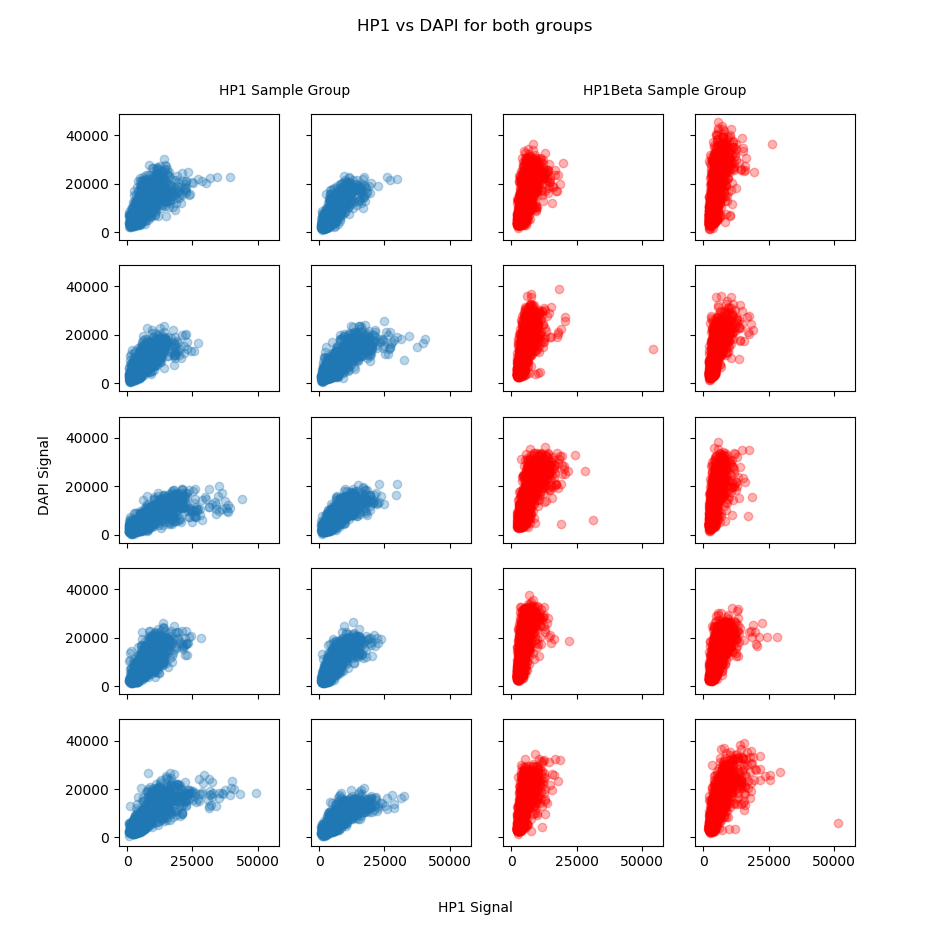

Text(0.7, 0.9, 'HP1Beta Sample Group')

In [44]:
fig, ax = plt.subplots(5, 4, sharex='all', sharey='all',figsize=(9.5,9.5))

fig.suptitle('HP1 vs DAPI for both groups')


ax[0,0].scatter(hp1Sample.loc[0,'HP1'], hp1Sample.loc[0,'DAPI'],alpha=0.3)
ax[0,1].scatter(hp1Sample.loc[1,'HP1'], hp1Sample.loc[1,'DAPI'],alpha=0.3)
ax[0,2].scatter(hp1betaSample.loc[0,'HP1'], hp1betaSample.loc[0,'DAPI'],alpha=0.3,color='red')
ax[0,3].scatter(hp1betaSample.loc[1,'HP1'], hp1betaSample.loc[1,'DAPI'],alpha=0.3,color='red')
ax[1,0].scatter(hp1Sample.loc[2,'HP1'], hp1Sample.loc[2,'DAPI'],alpha=0.3)
ax[1,1].scatter(hp1Sample.loc[3,'HP1'], hp1Sample.loc[3,'DAPI'],alpha=0.3)
ax[1,2].scatter(hp1betaSample.loc[2,'HP1'], hp1betaSample.loc[2,'DAPI'],alpha=0.3,color='red')
ax[1,3].scatter(hp1betaSample.loc[3,'HP1'], hp1betaSample.loc[3,'DAPI'],alpha=0.3,color='red')
ax[2,0].scatter(hp1Sample.loc[4,'HP1'], hp1Sample.loc[4,'DAPI'],alpha=0.3)
ax[2,1].scatter(hp1Sample.loc[5,'HP1'], hp1Sample.loc[5,'DAPI'],alpha=0.3)
ax[2,2].scatter(hp1betaSample.loc[4,'HP1'], hp1betaSample.loc[4,'DAPI'],alpha=0.3,color='red')
ax[2,3].scatter(hp1betaSample.loc[5,'HP1'], hp1betaSample.loc[5,'DAPI'],alpha=0.3,color='red')
ax[3,0].scatter(hp1Sample.loc[6,'HP1'], hp1Sample.loc[6,'DAPI'],alpha=0.3)
ax[3,1].scatter(hp1Sample.loc[7,'HP1'], hp1Sample.loc[7,'DAPI'],alpha=0.3)
ax[3,2].scatter(hp1betaSample.loc[6,'HP1'], hp1betaSample.loc[6,'DAPI'],alpha=0.3,color='red')
ax[3,3].scatter(hp1betaSample.loc[7,'HP1'], hp1betaSample.loc[7,'DAPI'],alpha=0.3,color='red')
ax[4,0].scatter(hp1Sample.loc[8,'HP1'], hp1Sample.loc[8,'DAPI'],alpha=0.3)
ax[4,1].scatter(hp1Sample.loc[9,'HP1'], hp1Sample.loc[9,'DAPI'],alpha=0.3)
ax[4,2].scatter(hp1betaSample.loc[8,'HP1'], hp1betaSample.loc[8,'DAPI'],alpha=0.3,color='red')
ax[4,3].scatter(hp1betaSample.loc[9,'HP1'], hp1betaSample.loc[9,'DAPI'],alpha=0.3,color='red')

fig.text(0.5, 0.04, 'HP1 Signal', ha='center')
fig.text(0.04, 0.5, 'DAPI Signal', va='center', rotation='vertical')

fig.text(0.30, 0.90, 'HP1 Sample Group', ha='center')
fig.text(0.70, 0.9, 'HP1Beta Sample Group', ha='center')


# using plotly for the similar plots

In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[0,'HP1'],
    y=hp1betaSample.loc[0,'DAPI'],
    name=hp1betaSample.loc[0,'File'].split('.')[0],
    mode='markers'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[1,'HP1'],
    y=hp1betaSample.loc[1,'DAPI'],
    name=hp1betaSample.loc[1,'File'].split('.')[0],
    mode='markers'
), row=2, col=1)


fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[2,'HP1'],
    y=hp1betaSample.loc[2,'DAPI'],
    name=hp1betaSample.loc[2,'File'].split('.')[0],
    mode='markers'
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[3,'HP1'],
    y=hp1betaSample.loc[3,'DAPI'],
    name=hp1betaSample.loc[3,'File'].split('.')[0],
    mode='markers'
), row=4, col=1)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[4,'HP1'],
    y=hp1betaSample.loc[4,'DAPI'],
    name=hp1betaSample.loc[4,'File'].split('.')[0],
    mode='markers'
), row=5, col=1)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[5,'HP1'],
    y=hp1betaSample.loc[5,'DAPI'],
    name=hp1betaSample.loc[5,'File'].split('.')[0],
    mode='markers'
), row=1, col=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[6,'HP1'],
    y=hp1betaSample.loc[6,'DAPI'],
    name=hp1betaSample.loc[6,'File'].split('.')[0],
    mode='markers'
), row=2, col=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[7,'HP1'],
    y=hp1betaSample.loc[7,'DAPI'],
    name=hp1betaSample.loc[7,'File'].split('.')[0],
    mode='markers'
), row=3, col=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[8,'HP1'],
    y=hp1betaSample.loc[8,'DAPI'],
    name=hp1betaSample.loc[8,'File'].split('.')[0],
    mode='markers'
), row=4, col=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[9,'HP1'],
    y=hp1betaSample.loc[9,'DAPI'],
    name=hp1betaSample.loc[9,'File'].split('.')[0],
    mode='markers'
), row=5, col=2)


fig.update_layout(height=800, width=800, title_text="HP1Beta vs DAPI signals",
                  annotations=[
        dict(
            x=0.5,
            y=-0.07,
            showarrow=False,
            text="HP1Beta Signal",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.1,
            y=0.5,
            showarrow=False,
            text="DAPI Signal",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    ],
    autosize=True,
    margin=dict(
        b=100
    ))


fig.show()

In [57]:
fig = make_subplots(rows=5, cols=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[0,'HP1'],
    y=hp1Sample.loc[0,'DAPI'],
    name=hp1Sample.loc[0,'File'].split('.')[0],
    mode='markers'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[1,'HP1'],
    y=hp1Sample.loc[1,'DAPI'],
    name=hp1Sample.loc[1,'File'].split('.')[0],
    mode='markers'
), row=2, col=1)


fig.append_trace(go.Scatter(
    x=hp1Sample.loc[2,'HP1'],
    y=hp1Sample.loc[2,'DAPI'],
    name=hp1Sample.loc[2,'File'].split('.')[0],
    mode='markers'
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[3,'HP1'],
    y=hp1Sample.loc[3,'DAPI'],
    name=hp1Sample.loc[3,'File'].split('.')[0],
    mode='markers'
), row=4, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[4,'HP1'],
    y=hp1Sample.loc[4,'DAPI'],
    name=hp1Sample.loc[4,'File'].split('.')[0],
    mode='markers'
), row=5, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[5,'HP1'],
    y=hp1Sample.loc[5,'DAPI'],
    name=hp1Sample.loc[5,'File'].split('.')[0],
    mode='markers'
), row=1, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[6,'HP1'],
    y=hp1Sample.loc[6,'DAPI'],
    name=hp1Sample.loc[6,'File'].split('.')[0],
    mode='markers'
), row=2, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[7,'HP1'],
    y=hp1Sample.loc[7,'DAPI'],
    name=hp1Sample.loc[7,'File'].split('.')[0],
    mode='markers'
), row=3, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[8,'HP1'],
    y=hp1Sample.loc[8,'DAPI'],
    name=hp1Sample.loc[8,'File'].split('.')[0],
    mode='markers'
), row=4, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[9,'HP1'],
    y=hp1Sample.loc[9,'DAPI'],
    name=hp1Sample.loc[9,'File'].split('.')[0],
    mode='markers'
), row=5, col=2)


fig.update_layout(height=800, width=800, title_text="HP1 vs DAPI signals",
                 annotations=[
        dict(
            x=0.5,
            y=-0.07,
            showarrow=False,
            text="HP1 Signal",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.1,
            y=0.5,
            showarrow=False,
            text="DAPI Signal",
            textangle=-90,
            xref="paper",
            yref="paper"
        )
    ],
    autosize=True,
    margin=dict(
        b=100
    ))
fig.show()

In [65]:
fig = make_subplots(rows=5, cols=4)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[0,'HP1'],
    y=hp1Sample.loc[0,'DAPI'],
    name=hp1Sample.loc[0,'File'].split('.')[0],
    mode='markers'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[1,'HP1'],
    y=hp1Sample.loc[1,'DAPI'],
    name=hp1Sample.loc[1,'File'].split('.')[0],
    mode='markers'
), row=2, col=1)


fig.append_trace(go.Scatter(
    x=hp1Sample.loc[2,'HP1'],
    y=hp1Sample.loc[2,'DAPI'],
    name=hp1Sample.loc[2,'File'].split('.')[0],
    mode='markers'
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[3,'HP1'],
    y=hp1Sample.loc[3,'DAPI'],
    name=hp1Sample.loc[3,'File'].split('.')[0],
    mode='markers'
), row=4, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[4,'HP1'],
    y=hp1Sample.loc[4,'DAPI'],
    name=hp1Sample.loc[4,'File'].split('.')[0],
    mode='markers'
), row=5, col=1)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[5,'HP1'],
    y=hp1Sample.loc[5,'DAPI'],
    name=hp1Sample.loc[5,'File'].split('.')[0],
    mode='markers'
), row=1, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[6,'HP1'],
    y=hp1Sample.loc[6,'DAPI'],
    name=hp1Sample.loc[6,'File'].split('.')[0],
    mode='markers'
), row=2, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[7,'HP1'],
    y=hp1Sample.loc[7,'DAPI'],
    name=hp1Sample.loc[7,'File'].split('.')[0],
    mode='markers'
), row=3, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[8,'HP1'],
    y=hp1Sample.loc[8,'DAPI'],
    name=hp1Sample.loc[8,'File'].split('.')[0],
    mode='markers'
), row=4, col=2)

fig.append_trace(go.Scatter(
    x=hp1Sample.loc[9,'HP1'],
    y=hp1Sample.loc[9,'DAPI'],
    name=hp1Sample.loc[9,'File'].split('.')[0],
    mode='markers'
), row=5, col=2)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[0,'HP1'],
    y=hp1betaSample.loc[0,'DAPI'],
    name=hp1betaSample.loc[0,'File'].split('.')[0],
    mode='markers'
), row=1, col=3)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[1,'HP1'],
    y=hp1betaSample.loc[1,'DAPI'],
    name=hp1betaSample.loc[1,'File'].split('.')[0],
    mode='markers'
), row=2, col=3)


fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[2,'HP1'],
    y=hp1betaSample.loc[2,'DAPI'],
    name=hp1betaSample.loc[2,'File'].split('.')[0],
    mode='markers'
), row=3, col=3)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[3,'HP1'],
    y=hp1betaSample.loc[3,'DAPI'],
    name=hp1betaSample.loc[3,'File'].split('.')[0],
    mode='markers'
), row=4, col=3)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[4,'HP1'],
    y=hp1betaSample.loc[4,'DAPI'],
    name=hp1betaSample.loc[4,'File'].split('.')[0],
    mode='markers'
), row=5, col=3)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[5,'HP1'],
    y=hp1betaSample.loc[5,'DAPI'],
    name=hp1betaSample.loc[5,'File'].split('.')[0],
    mode='markers'
), row=1, col=4)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[6,'HP1'],
    y=hp1betaSample.loc[6,'DAPI'],
    name=hp1betaSample.loc[6,'File'].split('.')[0],
    mode='markers'
), row=2, col=4)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[7,'HP1'],
    y=hp1betaSample.loc[7,'DAPI'],
    name=hp1betaSample.loc[7,'File'].split('.')[0],
    mode='markers'
), row=3, col=4)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[8,'HP1'],
    y=hp1betaSample.loc[8,'DAPI'],
    name=hp1betaSample.loc[8,'File'].split('.')[0],
    mode='markers'
), row=4, col=4)

fig.append_trace(go.Scatter(
    x=hp1betaSample.loc[9,'HP1'],
    y=hp1betaSample.loc[9,'DAPI'],
    name=hp1betaSample.loc[9,'File'].split('.')[0],
    mode='markers'
), row=5, col=4)

fig.update_layout(height=1000, width=1000, title_text="HP1 vs DAPI for both groups",
    annotations=[
        dict(
            x=0.5,
            y=-0.07,
            showarrow=False,
            text="HP1 Signal",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=-0.1,
            y=0.5,
            showarrow=False,
            text="DAPI Signal",
            textangle=-90,
            xref="paper",
            yref="paper"
        ),
        dict(
            x=0.15,
            y=1.025,
            showarrow=False,
            text="HP1 Sample Group",
            xref="paper",
            yref="paper"
        ),
        dict(
            x=0.85,
            y=1.025,
            showarrow=False,
            text="HP1Beta Sample Group",
            xref="paper",
            yref="paper"
        )
    ],
    autosize=True,
    margin=dict(
        b=100
    ))
fig.show()